In [2]:
import time
import os

import carla
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
client = carla.Client('localhost', 2000)
world = client.get_world()
spectator = world.get_spectator()
vehicles_bp = [bp for bp in world.get_blueprint_library().filter('vehicle.*') if 'bike' not in bp.id]
spawn_points = world.get_map().get_spawn_points()

In [3]:
def destroy_vehicles():
    for actor in world.get_actors().filter('vehicle.*'):
        actor.destroy()

In [4]:
def spawn_random_vehicles(n_vehicles, vehicles_bp, spawn_points, autopilot=True):
    for _ in range(n_vehicles):
        veh = world.try_spawn_actor(random.choice(vehicles_bp), random.choice(spawn_points))
        if veh and autopilot:
            veh.set_autopilot(True)

    ego_vehicle = None
    while ego_vehicle is None:
        ego_vehicle = world.try_spawn_actor(random.choice(vehicles_bp), random.choice(spawn_points))
    if autopilot:
        ego_vehicle.set_autopilot(True)
    
    return ego_vehicle

In [5]:
destroy_vehicles()
ego_vehicle = spawn_random_vehicles(10, vehicles_bp, spawn_points)

In [6]:
spectator.set_transform(ego_vehicle.get_transform())

## Setting up sensors

### IMU settings

In [10]:
def imu_callback(data):
    global imu_data
    timestamp = data.timestamp
    acc = data.accelerometer
    gyro = data.gyroscope
    compass = data.compass

    values = [[timestamp, acc.x, acc.y, acc.z, gyro.x, gyro.y, gyro.z, np.rad2deg(compass)]]
    new_data = pd.DataFrame(values, columns=imu_data.columns)

    imu_data = pd.concat([imu_data, new_data], ignore_index=True)

In [11]:
def set_attributes_IMU(imu_bp, sensor_tick=0.01, acc_noise=0.001, gyro_std=0.001, gyro_mean=0.001):
    imu_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    imu_bp.set_attribute('noise_accel_stddev_x', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (X axis).
    imu_bp.set_attribute('noise_accel_stddev_y', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Y axis).
    imu_bp.set_attribute('noise_accel_stddev_z', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Z axis).
    imu_bp.set_attribute('noise_gyro_stddev_x', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_stddev_y', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_stddev_z', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Z axis).
    imu_bp.set_attribute('noise_gyro_bias_x', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_bias_y', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_bias_z', f'{gyro_mean}')  # Mean parameter in the noise model for gyroscope (Z axis).


In [12]:
IMU_bp = world.get_blueprint_library().find('sensor.other.imu')
set_attributes_IMU(IMU_bp, sensor_tick=0.01, acc_noise=0.1, gyro_std=0.1, gyro_mean=0.1)

### GNSS settings

In [20]:
def gnss_callback(data):
    global gnss_data
    timestamp = data.timestamp
    latitude = data.latitude
    longitude = data.longitude

    values = [[timestamp, latitude, longitude]]
    new_data = pd.DataFrame(values, columns=gnss_data.columns)

    gnss_data = pd.concat([gnss_data, new_data], ignore_index=True)

In [21]:
def set_attributes_GNSS(gnss_bp, sensor_tick=0.01, lat_bias=0.1, lat_sttdev=0.1, lon_bias=0.1, lon_stddev=0.1):
    gnss_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    gnss_bp.set_attribute('noise_lat_bias', f'{lat_bias}') # Mean parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lat_stddev', f'{lat_sttdev}') # Standard deviation parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lon_bias', f'{lon_bias}') # Mean parameter in the noise model for longitude.
    gnss_bp.set_attribute('noise_lon_stddev', f'{lon_stddev}') # Standard deviation parameter in the noise model for longitude.

In [22]:
GNSS_bp = world.get_blueprint_library().find('sensor.other.gnss')
set_attributes_GNSS(GNSS_bp, sensor_tick=0.01)

## Colleting data

In [24]:
global imu_data
# timestamp: simulation time - s
# acc: m/s^2
# gyro: rad/s
# compass: rad
imu_data = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

global gnss_data
# timestamp: simulation time - s
# latitude: rad
# longitude: rad
# orientation: rad
gnss_data = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

GNSS = world.spawn_actor(GNSS_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)
IMU = world.spawn_actor(IMU_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)

GNSS.listen(lambda data: gnss_callback(data))
IMU.listen(lambda data: imu_callback(data))
try:
    time.sleep(10)
finally:
    IMU.stop()
    GNSS.stop()
    IMU.destroy()
    GNSS.destroy()

/tmp/ipykernel_11801/1253765034.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gnss_data = pd.concat([gnss_data, new_data], ignore_index=True)
/tmp/ipykernel_11801/2506951944.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imu_data = pd.concat([imu_data, new_data], ignore_index=True)


## Plot sensors

In [32]:
def plot_sensors(imu_dataframe, gnss_dataframe):

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax = ax.flatten()

    timestamp = imu_dataframe['timestamp'] - imu_dataframe['timestamp'].iloc[0]

    ax[0].plot(timestamp, imu_dataframe['acc_x'], label='acc_x')
    ax[0].plot(timestamp, imu_dataframe['acc_y'], label='acc_y')
    ax[0].plot(timestamp, imu_dataframe['acc_z'], label='acc_z')
    ax[0].set_title('Accelerometer')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Acceleration [m/s^2]')
    ax[0].legend()

    ax[1].plot(timestamp, imu_dataframe['gyro_x'], label='gyro_x')
    ax[1].plot(timestamp, imu_dataframe['gyro_y'], label='gyro_y')
    ax[1].plot(timestamp, imu_dataframe['gyro_z'], label='gyro_z')
    ax[1].set_title('Gyroscope')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Angular velocity [rad/s]')
    ax[1].legend()

    ax[2].plot(timestamp, imu_dataframe['compass'], label='compass')
    ax[2].set_title('Compass')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Heading [rad]')
    ax[2].legend()

    timestamp = gnss_dataframe['timestamp'] - gnss_dataframe['timestamp'].iloc[0]
    ax[3].plot(timestamp, gnss_dataframe['latitude'], label='latitude')
    ax[3].plot(timestamp, gnss_dataframe['longitude'], label='longitude')
    ax[3].set_title('GNSS')
    ax[3].set_xlabel('Time [s]')
    ax[3].set_ylabel('Position [rad]')
    ax[3].legend()

    plt.show()

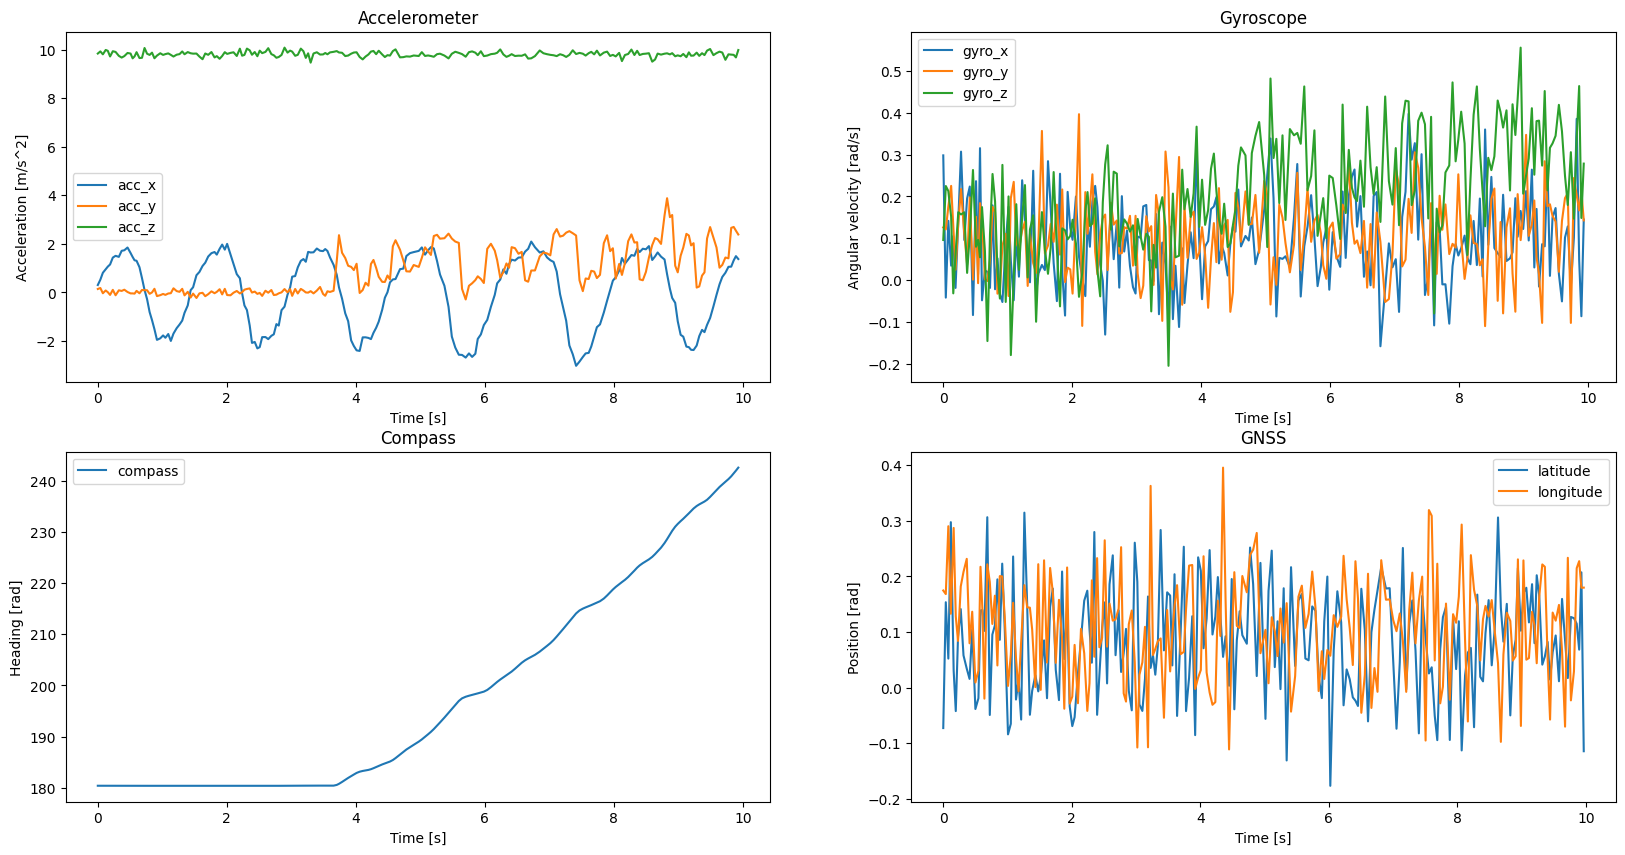

: 

In [ ]:
plot_sensors(imu_data[2:], gnss_data[2:])

## Global Route Planner

In [ ]:
from agents.navigation.global_route_planner import GlobalRoutePlanner

ModuleNotFoundError: No module named 'agents'

: 

## Traffic Manager

Vehicle behavior considerations

The TM implements general behavior patterns that must be taken into consideration when you set vehicles to autopilot:

- Vehicles are not goal-oriented, they follow a dynamically produced trajectory and choose a path randomly when approaching a junction. Their path is endless.
- Vehicles' target speed is 70% of their current speed limit unless any other value is set.
- Junction priority does not follow traffic regulations. The TM uses its own priority system at junctions. The resolution of this restriction is a work in progress. In the meantime, some issues may arise, for example, vehicles inside a roundabout yielding to a vehicle trying to get in.
